## PINN(Physics Informed Neural Networks)

### Importing neccessary lib

In [73]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

### Generate synthetic Data

In [74]:
# -------------------
# 1. Generate Synthetic Data
# --------------------

#Physics parameters
g = 9.8 # accelaration due to gravity
h0 = 1.0 # initial state(height)
v0 = 10.0 # initial velocity

# True (physics) solution h(t) = h0 + v0*t - 0.5g*t^2
def true_physics(t):
    return h0 + v0*t - 0.5*g*(t**2)

#Generate some time points
t_min , t_max = 0.0, 6.0
N_data = 10 # data points
t_data = np.linspace(t_min,t_max,N_data)

#Genearate synthetic "experimental" heights with noise
np.random.seed(0)
noise_level = 0.7
h_data_exact = true_physics(t_data)
h_data_nosiy = h_data_exact + noise_level*np.random.randn(N_data)

#Convert to pytorch tensors
t_data_tensor = torch.tensor(t_data,dtype=torch.float32).view(-1,1)
h_data_tensor = torch.tensor(h_data_nosiy, dtype=torch.float32).view(-1,1)

### Define a small feed-forward neural network for h(t)

In [75]:
class PINN(nn.Module):
    def __init__(self,n_hidden = 20):
        super(PINN,self).__init__()
        # A simple MLP with 2 hidden layers
        self.net = nn.Sequential(
            nn.Linear(1,n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden,n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden,1)
        )
    
    def forward(self,t):
        """
        Forward pass: input shape (batch_size, 1) -> output shape (batch_size, 1)
        """
        return self.net(t)

#Instantiate the model
model = PINN(n_hidden=20)

### Helper for Automatic Differentiation

In [76]:
def dervative(y,x):
     """
    Computes dy/dx using PyTorch's autograd.
    y and x must be tensors with requires_grad=True for x.
    """
     return torch.autograd.grad(
          y,x,
          grad_outputs = torch.ones_like(y), # importance to each element w1*dy/dx , w1 is importance to that element
          create_graph = True # need graph to compute sceond derivative
     )[0]

### Define the loss Components(PINN)

In [77]:
# We have:
#    (1) Data loss (fit noisy data)
#    (2) ODE loss: dh/dt = v0 - g * t
#    (3) Initial condition loss: h(0) = h0
def physics_loss(model,t):
     """
    Compare d(h_pred)/dt with the known expression (v0 - g t).
    """
     # t must have requires_grad = True for autograd to work
     t.requires_grad_(True)

     h_pred = model(t)
     dh_dt_pred = dervative(h_pred,t)

     #For each t , physics says dh/dt = v0 - g *t
     dh_dt_true = v0 - g * t

     loss_ode = torch.mean((dh_dt_pred - dh_dt_true)**2)
     return loss_ode

def initial_condition_loss(model):
     """
    Enforce h(0) = h0.
    """
     # Evaluate at t=0
     t0 = torch.zeros(1,1,dtype=torch.float32
                      ,requires_grad = False)
     h0_pred = model(t0)
     return (h0_pred - h0).pow(2).mean()

def data_loss(model,t_data,h_data):
     """
    MSE between predicted h(t_i) and noisy measurements h_data.
    """
     h_pred = model(t_data)
     return torch.mean((h_pred - h_data)**2)
     

### Training Setup

In [78]:
# ---------------------------------------
# 5. Training Setup
# ---------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Hyperparameters for weighting the loss terms
lambda_data = 1.0
lambda_ode  = 0.5
lambda_ic   = 0.5

# For logging
num_epochs = 2000
print_every = 200

### Training Loop

In [79]:
# ---------------------------------------
# 6. Training Loop
# ---------------------------------------
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Compute losses
    l_data = data_loss(model, t_data_tensor, h_data_tensor)
    l_ode  = physics_loss(model, t_data_tensor)
    l_ic   = initial_condition_loss(model)

    # Combined loss
    loss = lambda_data * l_data + lambda_ode * l_ode + lambda_ic * l_ic

    # Backprop
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % print_every == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Total Loss = {loss.item():.6f}, "
              f"Data Loss = {l_data.item():.6f}, "
              f"ODE Loss = {l_ode.item():.6f}, "
              f"IC Loss = {l_ic.item():.6f}")

Epoch 200/2000, Total Loss = 1100.822144, Data Loss = 831.221863, ODE Loss = 524.606934, IC Loss = 14.593476
Epoch 400/2000, Total Loss = 470.657837, Data Loss = 316.345917, ODE Loss = 307.754913, IC Loss = 0.868874
Epoch 600/2000, Total Loss = 238.548508, Data Loss = 118.689316, ODE Loss = 239.656219, IC Loss = 0.062162
Epoch 800/2000, Total Loss = 69.896011, Data Loss = 60.928253, ODE Loss = 17.891460, IC Loss = 0.044047
Epoch 1000/2000, Total Loss = 28.170172, Data Loss = 27.502090, ODE Loss = 1.278037, IC Loss = 0.058125
Epoch 1200/2000, Total Loss = 16.228170, Data Loss = 15.097285, ODE Loss = 2.227538, IC Loss = 0.034235
Epoch 1400/2000, Total Loss = 6.189430, Data Loss = 5.416531, ODE Loss = 1.516618, IC Loss = 0.029181
Epoch 1600/2000, Total Loss = 2.887156, Data Loss = 2.791976, ODE Loss = 0.162202, IC Loss = 0.028159
Epoch 1800/2000, Total Loss = 2.467713, Data Loss = 1.615744, ODE Loss = 1.672514, IC Loss = 0.031425
Epoch 2000/2000, Total Loss = 2.138304, Data Loss = 1.08865

### Evaluate the Trained Model

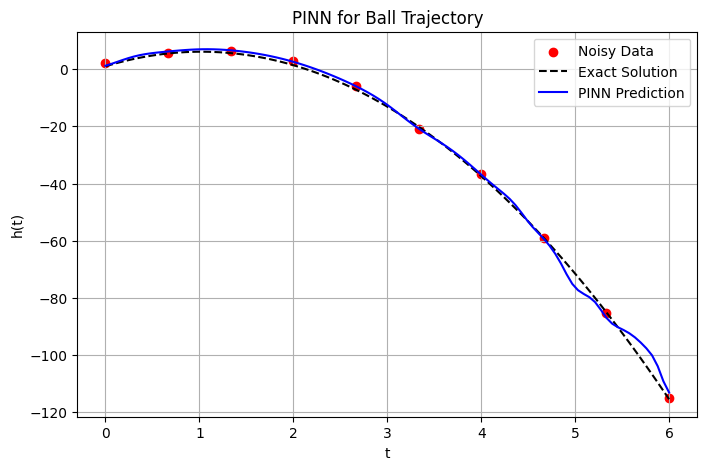

In [80]:
# ---------------------------------------
# 7. Evaluate the Trained Model
# ---------------------------------------
model.eval()
t_plot = np.linspace(t_min, t_max, 100).reshape(-1, 1).astype(np.float32)
t_plot_tensor = torch.tensor(t_plot, requires_grad=True)
h_pred_plot = model(t_plot_tensor).detach().numpy()

# True solution (for comparison)
h_true_plot = true_physics(t_plot)

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(t_data, h_data_nosiy, color='red', label='Noisy Data')
plt.plot(t_plot, h_true_plot, 'k--', label='Exact Solution')
plt.plot(t_plot, h_pred_plot, 'b', label='PINN Prediction')
plt.xlabel('t')
plt.ylabel('h(t)')
plt.legend()
plt.title('PINN for Ball Trajectory')
plt.grid(True)
plt.show()